# Urban Sounds Classification

## Kullanacağımız Kütüphaneler

* Kodu Colab'da yazdığımız için kullanacağımız ses, veri gibi materyalleri Google Drive'a atmak gerekiyor.

* drive.mount: Aynı Linux'ta olduğu gibi Drive'da da kök dizin vardır. Drive'da kök dizin /content/drive şeklindedir. Bu kod ile kök dizine bağlanılır.

* os.chdir: Linux'ta da olduğu gibi chdir komutu bizi istediğimiz klasöre atar. Dikkat edersen burada da /content/drive dosya yolu var. Ama ben My Drive dosyasına bağlanmak istiyorum. Bu dosya tıpkı Windows'ta Desktop gibi bir klasör. Yani Desktop'ın Google Drive'da karşılığı My Drive'dır.  UrbanSound8K.tar.gz(sıkıştırılmış dosya) dosyasını da My Drive içinde global_ai_hub diye daha önce oluşturduğum klasöre yüklemiştim. Bu yüzden chdir ile dosya yolunu buraya getirdim. Artık bu klasörün içindeyim.

In [1]:
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/global_ai_hub")

Mounted at /content/drive


## Diğer Kütüphaneler

* librosa: Bu kütüphane ses dosyalarını(mp3, wav gibi dosyalar) okumamızı sağlar.

* librosa.display: librosa'nın bir özelliği de ses dosyalarını resme çevirebilmesidir. Bunun için librosa'nın display metodunu kullanılır.

* cv2: OpenCV kütüphanesi, resimler üzerinde sonsuz sayıda işlemler yapmamızı sağlar. Resimleri okur, gösterir, resim üzerinde değişiklik yaparsak kaydeder. Küçültme, büyütme, renkli resimleri gri formata dönüştürme gibi daha bir sürü işlem yapmamız sağlar.

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import sys

* os.chdir ile global_ai_hub içine girmiştim. Daha önce global_ai_hub'ın içine UrbanSound8K.tar.gz sıkıştırılmış dosyasını yüklemiştim. Aşağıdaki komutla bu sıkıştırılmış dosyayı açtım.

In [ ]:
#Unzip  UrbanSound8K.tar.gz
!tar -xvf UrbanSound8K.tar.gz

Streaming output truncated to the last 5000 lines.
UrbanSound8K/audio/fold4/17480-2-0-6.wav
UrbanSound8K/audio/fold4/17480-2-0-9.wav
UrbanSound8K/audio/fold4/175904-2-0-11.wav
UrbanSound8K/audio/fold4/175904-2-0-24.wav
UrbanSound8K/audio/fold4/176003-1-0-0.wav
UrbanSound8K/audio/fold4/176638-5-0-0.wav
UrbanSound8K/audio/fold4/177756-2-0-10.wav
UrbanSound8K/audio/fold4/177756-2-0-4.wav
UrbanSound8K/audio/fold4/177756-2-0-5.wav
UrbanSound8K/audio/fold4/177756-2-0-7.wav
UrbanSound8K/audio/fold4/179862-1-0-0.wav
UrbanSound8K/audio/fold4/180977-3-1-1.wav
UrbanSound8K/audio/fold4/180977-3-1-5.wav
UrbanSound8K/audio/fold4/183989-3-1-21.wav
UrbanSound8K/audio/fold4/183989-3-1-23.wav
UrbanSound8K/audio/fold4/185709-0-0-0.wav
UrbanSound8K/audio/fold4/185709-0-0-1.wav
UrbanSound8K/audio/fold4/185709-0-0-6.wav
UrbanSound8K/audio/fold4/185709-0-0-7.wav
UrbanSound8K/audio/fold4/185909-2-0-102.wav
UrbanSound8K/audio/fold4/185909-2-0-13.wav
UrbanSound8K/audio/fold4/185909-2-0-17.wav
UrbanSound8K/audio

## 0. Resim Dosyaları Oluşturma

* Sıkıştırılmış dosyayı açınca içinde sound ve metadata adında iki klasör olan bir klasör gelmiş olacak. sound klasöründe ses dosyaları var, metadata içinde de bir tablo dosyası var(UrbanSound8K.csv). Bu dosyayı pandas kütüphanesi vasıtasıyla açalım.


* En soldaki sütunda ses dosyalarının isimleri var. Dikkat edersen dosya isminde ilk "-" ifadesinden sonraki numara sınıf/etiket'lerdir. classID sütunundaki etiketlerle bu numaraların aynı olduğunu aşağıdaki tablodan görebilirsin. Dolayısıyla ileride bu dosyaların etiketlerine dosya isimlerinden(100032-'3'-0-0.wav gibi) erişeceğiz.

* Toplam 10 adet etiket var. Detayları da şöyle:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

In [3]:
import pandas as pd
df=pd.read_csv("/content/drive/My Drive/global_ai_hub/UrbanSound8K/metadata/UrbanSound8K.csv")
df.head(15)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


* İlk amacımız, ses dosyalarını resimlere dönüştürüp etiketlerine göre bir klasöre atmak. Yani her etiket için bir klasör olacak(toplam 10 etiket olduğu için 10 klasör olacak) ve her klasör bir etiketin resimlerini tutacak. Mesela '8' adında klasör, 8(siren) etiketli ses dosyalarının resimlerini tutsun istiyoruz. 

* Bunun için evvela bu 10 klasörü içeren "our_spectrograms" adında bir klasör oluşturalım. Daha sonra bunun içine 0'dan 9'a klasör oluşturalım. 

In [5]:
os.mkdir("our_spectrograms") #Ana Klasör

In [11]:
#Toplam 10 Sınıf var
num_of_classes=10 
#0'dan 9'a isimlendirilmiş 10 klasörü bu dosya yoluna atacağız.
main_folder= "/content/drive/My Drive/global_ai_hub/our_spectrograms" 

* Aşağıdaki komutu çalıştırdığımızda 0, 1, 2, 3, ... , 8, 9 isimlerinde 10 klasör oluşmuş olacak.

In [5]:
os.mkdir(main_folder)
for i in range(num_of_classes):
  os.mkdir(main_folder+"/"+str(i))

## 1. Spectrogram Oluşturma 

* UrbanSound8K.tar.gz'den çıkarttığımız ses dosyalarını resime dönüştürelim.

* Aşağıdaki fonksiyon, proje dökümanında vardı. Aynen aldım. Bu fonksiyona bir ses dosyası verirsen onu ham resme dönüştürüyor. Dolayısıyla elimizdeki tüm ses dosyalarını bu fonksiyona vermemiz gerekiyor. 

In [7]:
def create_spectrogram(y):
  spec= librosa.feature.melspectrogram(y=y)
  spec_conv=librosa.amplitude_to_db(spec, ref=np.max)
  return spec_conv #Ham Resim

* Aşağıdaki fonksiyon ise ham resmi gerçek renkli resme dönüştürecek ve kaydedecek.

* Bu foknsiyon iki parametre alıyor:

=> SOUND_PATH: Ses dosyasının dosya yolu(/content/drive/My Drive/global_ai_hub/UrbanSound8K/sound/fold1/7061-6-0-0.wav gibi)

=> IMAGE_PATH: Sesi resme dönüştürdükten sonra resmi atacağımız dosya yolu(/content/drive/My Drive/global_ai_hub/our_spectrograms/6 gibi)

In [8]:
def save_image(SOUND_PATH, IMAGE_PATH):
  y, sr = librosa.load(SOUND_PATH)
  spec_conv=create_spectrogram(y)
  librosa.display.specshow(spec_conv, sr=sr)
  plt.savefig(IMAGE_PATH, bbox_inches='tight', pad_inches=0, transparent=True) #Resmi IMAGE_PATH'e kaydediyor.
  plt.close()

In [25]:
# fold1, fold2, fold3..., fold5 için 1,2,3,4,5 sayılarını dönsün:
for folder_index in range(1,6):
  #/content/drive/My Drive/global_ai_hub/UrbanSound8K/audio/fold1 gibi dosya yolları oluşturalım:
  sound_folder="/content/drive/My Drive/global_ai_hub/UrbanSound8K/audio/fold"+str(folder_index)
  #os.listdir linux'taki ls komutu ile aynı. İçindeki dosya isimlerinin hepsini liste yapıp bize veriyor.
  for sound_file in os.listdir(sound_folder):
    if sound_file.endswith(".wav"): #Sadece .wav uzantılı dosyaları alsın.
        sound_label=sound_file.split("-")[1] # Ses dosyasının etiketi. 3(dog bark) gibi
        sound_name=sound_file.split(".")[0] #Ses dosyasının uzantısız ismi. 9223-2-0-4.wav'ın 9223-2-0-4 ismi gibi
        save_image(sound_folder+"/"+sound_file, main_folder+"/"+sound_label+"/"+sound_name+".png") #Bir üstteki fonksiyon ile resmi kaydedelim.

* Artık resimleri oluşturduk. Drive'daki our_spectrograms resim dosyasının içindeki dosyalara bakarsan resimlerin etiketlerine göre dosyalara kaydedilmiş olduklarını görebilirsin. 

## 2. Önişleme - Notebook
a. Görüntüleri (spectrogramları) sırasıyla okuyarak, grayscale dönüşümü, resizing ve normalizasyon yapın.

b. Görüntüleri ait oldukları etiketlerle birlikte, [görüntü, etiket] formatında bir listeye ekleyin.

c. Bu listeyi kullanarak, X_train, y_train, X_val, y_val, X_test ve y_test veri setlerini oluşturun.

d. Bu veri setlerini bilgisayarınıza kaydedin.


* Artık ses dosyalarıyla bir işimiz kalmadı. Ses dosyalarını renkli resimlere dönüştürdük ve etiketlerine göre birbirlerinden ayırdık.

* Hatırlarsan "our_spectrograms" klasörünün dosya yolunu main_folder adında bir değişkene kaydetmiştik. Resimlerimizi buradan çekeceğiz.

In [16]:
main_folder

'/content/drive/My Drive/global_ai_hub/our_spectrograms'

### Ön işleme aşamasında üç hedef var: 

=> İlk önce renkli resimleri gri hale çevireceğiz. 

=> Resimlerin boyutları birbirinden farklı. CNN'de eğitim yapabilmemiz için resimleri aynı boyuta sokmamız şart. Bunun için resimlerin hepsini aynı boyuta sokacağız. (ben hepsini (100,100) formuna sokmayı tercih ettim)

=> Resimler 0-255 arası değerler alıyor. 100, 200 gibi sayılarla eğitim yapmak bir hesap yükü getiriyor. Bu yüzden bu piksel değerlerini 0(min)-1(max) arasına çekmek(normalizasyon) eğitimi kolaylaştıracaktır.

In [26]:
X=[] #Tüm resimleri tutacak dizi
y=[] #Tüm resimlerin etiketlerini tutacak dizi
# Her etiket dosyası ismi için(0, 1, 2, 3, 4, ..., 8, 9) sayı dönsün: 
for label in range(10):
  #Linux'taki ls komutunda olduğu gibi her etiket dosyasının içine baksın ve içindeki tüm dosyaları versin.
  images=os.listdir(main_folder+"/"+str(label))  
  # İçteki for döngüsü ile sırasıyla tüm resimleri gezsin.
  for image_index in range(len(images)):
    img_gray=cv2.imread(main_folder+"/"+str(label)+"/"+images[image_index],0) #Renkli resmi gri olarak(0:gri, 1:renkli) oku.
    resized_gray = cv2.resize(img_gray, (100,100) , interpolation = cv2.INTER_AREA) #Resmi (100,100) boyutuna getir.
    #Resimlerdeki piksellerdeki en büyük değer 255 olduğu için tüm pikselleri 255'e böl.
    normalized_gray=resized_gray/255 #Bu sayede tüm piksel değerleri 0-1 arasında olacak.
    X.append(normalized_gray) #İşlenmiş resmi X listesine ekle.
    y.append(label) #İşlenmiş resmin etiketini y listesine ekle.

* Tüm resimleri X listesine, etiketlerini de y listesine ekledik.

* Toplam Resim Sayısı=4612

In [27]:
print(len(X))
print(len(y))

4612
4612


* Veriyi train, validation ve test için böleceğiz. Ama bir problem var :)

* Resimleri ve etiketleri eklerken dikkat ettiysen 0,0,0,0,0...0,1,1,1,...,1,2,2,2,2,2...8,8,8,8,8...,8,8,9,9,9,9,...,9,9 şeklinde ekledik. Göstereyim:

In [30]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


* Eğer veriyi bu halde bölmeye kalkarsak mesela train kısmında 0'dan 7'e kadar, valid kısmında 7'den 8'e, test kısmında 8'den 9'a kadarki etiketli resimleri almak gibi bir senaryo oluşur. Dolayısıyla train verisiyle eğitilen model 7, 8 ve 9 etiketlerini göremez. Dolayısıyla X ve y listesini(aynı hizada) karıştırmamız lazım ki train, valid ve test bölümünde her bölüm için tüm sınıflar var olabilsin.

* Aşağıdaki fonksiyonu internetten buldum. X'i ve y'yi hizalayıp karıştırıyor, sonra tekrar X ve y olarak bize veriyor. Bu şekilde bu problemden de kurtulmuş olduk.

In [31]:
import random
def shuffle_xy(X,y):
  z = list(zip(X, y))
  random.shuffle(z)
  X, y = zip(*z)
  return X, y

In [33]:
# Örnek:
veri=[1, 2, 3]
etiket=["bir", "iki", "üç"]
karıştırılmış_veri, karıştırılmış_etiket=shuffle_xy(veri, etiket)
print(karıştırılmış_veri)
print(karıştırılmış_etiket)

(2, 1, 3)
('iki', 'bir', 'üç')


In [38]:
X, y=shuffle_xy(X, y) #Resim listesi(X) ve etiket listesi(y)'ni aynı hizada karıştıralım.

* Artık veriyi train(%85), valid(%10), test(%5) olarak bölebiliriz. Bölme oranları istenildiği gibi oluşturulabilir.

In [39]:
train_per=0.85
val_per=0.1
test_per=0.05
total_size=len(X) #Elimizdeki toplam veri sayısı

# 0'dan başlayıp toplam veri sayısının %85'ine kadarki kısmı train için ayır. Aynı şeyi etiketleri için de yap.
X_train=np.array(X[:int(total_size*train_per)]) 
y_train=np.array(y[:int(total_size*train_per)]) 

# X'in %85'lik kısmının son elemanından başlayıp %95'lik kısmına kadar validasyon verisi için ayır. Aynı şeyi etiketleri için de yap.
X_val=np.array(X[int(total_size*train_per):int(total_size*(train_per+val_per))]) 
y_val=np.array(y[int(total_size*train_per):int(total_size*(train_per+val_per))])

# X'in %95'lik kısmının son elemanından başlayıp X'in son elemanına kadar ayır. Aynı şeyi etiketleri için de yap.
X_test=np.array(X[int(total_size*(train_per+val_per)):])
y_test=np.array(y[int(total_size*(train_per+val_per)):])

* Not: X ve y'yi ayrı ayrı np.array fonksiyonuna soktuk. Yani hepsini listeden numpy array'ine dönüştürdük. Çünkü kuracağımız model sadece numpy array'lerini kabul ediyor.

* Bölme işlemi sonucu:

Train Veri Sayısı: 3920

Validasyon Veri Sayısı: 461

Test Veri Sayısı: 231

In [40]:
print(f"Len of X_train:{len(X_train)}")
print(f"Len of y_train:{len(y_train)}")
print(f"Len of X_val:{len(X_val)}")
print(f"Len of y_val:{len(y_val)}")
print(f"Len of X_test:{len(X_test)}")
print(f"Len of y_test:{len(y_test)}")

Len of X_train:3920
Len of y_train:3920
Len of X_val:461
Len of y_val:461
Len of X_test:231
Len of y_test:231


* Eğitim için kullanılacak X_train array'inin boyutu (3920, 100, 100) şeklinde. Bunun anlamı; X_train içinde (100,100) boyutunda 3920 adet resim var.

* y_train array'inin boyutu ise (3920,) şeklinde. Bunun anlamı; 3920 adet 0 boyutlu(bildiğimiz 3, 5 gibi sayılar) etiket var.

In [42]:
print(X_train.shape)
print(y_train.shape)
print("y_train'nin ilk 10 elemanı:")
print(y_train[0:10])

(3920, 100, 100)
(3920,)
y_train'nin ilk 10 elemanı:
[6 4 5 9 2 7 4 8 2 7]


## 3. Model Hazırlanması ve Eğitimi - Notebook
a. Bir CNN modeli hazırlayın.

b. Modeli hazırlamış olduğunuz veriyi kullanarak eğitin.

c. Modelin performans metriklerini, loss ve accuracy grafiklerini ekrana yazdırın.

d. Aldığınız sonuçlara göre hyperparameter optimization yapın.

In [46]:
# Konvolüsyon Katmanları:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu",
                                 input_shape=(100,100,1))) # Ön İşlemede tüm resimleri sabit (100,100) yapmıştık. 1 ifadesi resimlerin gri olduğunu
model.add(tf.keras.layers.MaxPool2D((2,2)))                # belirtiyor.
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))

#  Neural Network Katmanı:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [47]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [48]:
results=model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
31/31 [==============================] - 57s 2s/step - loss: 2.1978 - accuracy: 0.1686 - val_loss: 1.9803 - val_accuracy: 0.3514
Epoch 2/20
31/31 [==============================] - 52s 2s/step - loss: 1.9430 - accuracy: 0.2816 - val_loss: 1.5858 - val_accuracy: 0.4707
Epoch 3/20
31/31 [==============================] - 52s 2s/step - loss: 1.6385 - accuracy: 0.3964 - val_loss: 1.2661 - val_accuracy: 0.5206
Epoch 4/20
31/31 [==============================] - 54s 2s/step - loss: 1.4477 - accuracy: 0.4679 - val_loss: 1.1094 - val_accuracy: 0.6443
Epoch 5/20
31/31 [==============================] - 51s 2s/step - loss: 1.2886 - accuracy: 0.5334 - val_loss: 0.9695 - val_accuracy: 0.7158
Epoch 6/20
31/31 [==============================] - 53s 2s/step - loss: 1.1352 - accuracy: 0.5949 - val_loss: 0.8816 - val_accuracy: 0.7115
Epoch 7/20
31/31 [==============================] - 51s 2s/step - loss: 1.0472 - accuracy: 0.6296 - val_loss: 0.7911 - val_accuracy: 0.7722
Epoch 8/20
31/31 [==

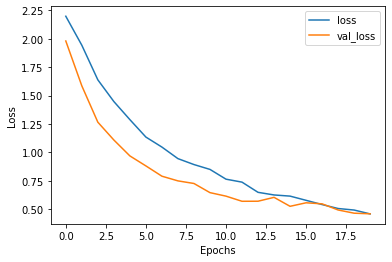

In [49]:
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

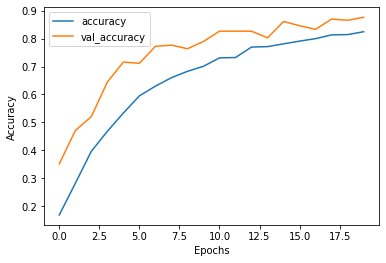

In [50]:
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [51]:
#Birinci eleman kaybı, ikinci eleman ise doğruluğu ifade ediyor.
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 97ms/step - loss: 0.4925 - accuracy: 0.8658


[0.49247679114341736, 0.8658008575439453]

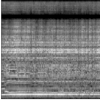

Label: 4
Prediction: 4
Prediction Probability: 100%


In [57]:
#Örnek Resim:
cv2_imshow(X_test[100]*255)
prediction_result=model.predict(X_test[100].reshape((1,100,100,1)))
prediction_result
predicted_class=prediction_result.argmax()
predicted_probability=prediction_result.max()

print("Label: "+str(y_test[100]))
print("Prediction: "+str(predicted_class))
print("Prediction Probability: "+str(int(predicted_probability*100))+"%")

## 4. Sonuçların Yüklenmesi
a. Hazırladığınız notebookları, çıktı hücrelerini silmeden GitHub hesabınıza yükleyin.

b. https://forms.gle/tk9m8cRXTkLV2Phv8 linkinde bulunan formu doldurun.

c. Dosyaları herkes görüntüleyebilir şeklinde ayarlamayı unutmayın 